# Multi-Configuration Zoom Lens

This example demonstrates how to create, visualize, and optimize a multi-configuration zoom lens system using the `MultiConfiguration` class.

In [1]:
import numpy as np
from optiland.optic import Optic
from optiland.multiconfig import MultiConfiguration
from optiland.optimization import OptimizationProblem
from optiland.optimization import LeastSquares

## Define the Base Optical System

First, we define the base optical system (Configuration 0). This system represents the first zoom position.

Design reference: Milton Laikin, Lens Design, 2007, Pg. 362. Note this design is in inches = 25.4 mm.

In [ ]:
# Initialize the Optic
lens = Optic()

# Define Wavelengths (Standard Visible)
lens.add_wavelength(value=0.4861)  # F
lens.add_wavelength(value=0.5876, is_primary=True)  # d
lens.add_wavelength(value=0.6563)  # C

# Define Fields (On-axis and Edge)
lens.set_field_type("angle")
lens.add_field(y=0)
lens.add_field(y=14.93)
lens.add_field(y=28.07)

# Define Aperture
lens.set_aperture("imageFNO", 2.4)

# --- Surface Definition ---
# Note: Base configuration uses values for the first zoom position (EFL 0.591)

lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=1, radius=10.0697, thickness=1.2211, material="N-LAK9", aperture=5.8)
lens.add_surface(index=2, radius=-6.2327, thickness=0.2360, material="SF5", aperture=5.8)
lens.add_surface(index=3, radius=15.1603, thickness=0.0150, aperture=5.38)
lens.add_surface(index=4, radius=6.0741, thickness=0.4336, material="N-LAF21", aperture=5.26)
lens.add_surface(index=5, radius=12.9033, thickness=0.0903, aperture=5.2) # Variable T
lens.add_surface(index=6, radius=41.2877, thickness=0.1400, material="N-LAK9", aperture=2.42)
lens.add_surface(index=7, radius=1.7269, thickness=0.4613, aperture=2.0)
lens.add_surface(index=8, radius=-3.8953, thickness=0.1400, material="N-LAK9", aperture=2.0)
lens.add_surface(index=9, radius=1.2599, thickness=0.5386, material="SF5", aperture=1.96)
lens.add_surface(index=10, radius=-43.9995, thickness=5.7197, aperture=1.96) # Variable T
lens.add_surface(index=11, radius=3.4298, thickness=0.3125, material="N-LAK9", aperture=1.8)
lens.add_surface(index=12, radius=-4.9794, thickness=0.0150, aperture=1.8)
lens.add_surface(index=13, radius=1.6004, thickness=0.1698, material="SF1", aperture=1.68)
lens.add_surface(index=14, radius=0.7220, thickness=0.4947, material="N-LAK9", aperture=1.38)
lens.add_surface(index=15, radius=6.9314, thickness=0.0090, aperture=1.38) # Variable T
lens.add_surface(index=16, radius=np.inf, thickness=0.2934, is_stop=True)
lens.add_surface(index=17, radius=-1.2083, thickness=0.1191, material="N-LAK8", aperture=0.66)
lens.add_surface(index=18, radius=-2.8138, thickness=0.0984, material="SF1", aperture=0.7)
lens.add_surface(index=19, radius=1.9740, thickness=0.0659, aperture=0.7)
lens.add_surface(index=20, radius=-2.5527, thickness=0.3367, material="N-SF8", aperture=0.7)
lens.add_surface(index=21, radius=-0.8716, thickness=0.0200, aperture=0.86)
lens.add_surface(index=22, radius=1.9698, thickness=0.2970, material="N-BAK4", aperture=0.88)
lens.add_surface(index=23, radius=-0.7692, thickness=0.1000, material="SF1", aperture=0.88)
lens.add_surface(index=24, radius=-3.7908, thickness=0.9232, aperture=0.88)
lens.add_surface(index=25, radius=np.inf, thickness=0.0)

lens.set_ray_aiming("iterative", cache=True)

## Create Multi-Configuration Setup

We now initialize the `MultiConfiguration` object. The base optic is automatically assigned as Configuration 0.
We then add three additional configurations for different zoom positions. Both zoom positions and fields are defined for each additional configuration. In general, any property of the optic can be defined for any configuration.

In [3]:
# Multi-Configuration Setup
mc = MultiConfiguration(lens)

# Configuration 0 is the base (lens)
# Values are already set for Config 0 (EFL 0.591)

# Configuration 1 (EFL 1.272)
mc.add_configuration()
mc.set_thickness(surface_index=5, value=2.4124, configurations=[1])
mc.set_thickness(surface_index=10, value=3.2501, configurations=[1])
mc.set_thickness(surface_index=15, value=0.1566, configurations=[1])
# Update fields for configuration 1
mc.set_optic_property(attribute_path="fields.fields[1].y", value=7.05, configurations=[1])
mc.set_optic_property(attribute_path="fields.fields[2].y", value=13.9, configurations=[1])

# Configuration 2 (EFL 2.741)
mc.add_configuration()
mc.set_thickness(surface_index=5, value=4.0081, configurations=[2])
mc.set_thickness(surface_index=10, value=1.4376, configurations=[2])
mc.set_thickness(surface_index=15, value=0.3733, configurations=[2])
# Update fields for configuration 2
mc.set_optic_property(attribute_path="fields.fields[1].y", value=3.288, configurations=[2])
mc.set_optic_property(attribute_path="fields.fields[2].y", value=6.555, configurations=[2])

# Configuration 3 (EFL 5.905)
mc.add_configuration()
mc.set_thickness(surface_index=5, value=5.1199, configurations=[3])
mc.set_thickness(surface_index=10, value=0.0100, configurations=[3])
mc.set_thickness(surface_index=15, value=0.6891, configurations=[3])
# Update fields for configuration 3
mc.set_optic_property(attribute_path="fields.fields[1].y", value=1.528, configurations=[3])
mc.set_optic_property(attribute_path="fields.fields[2].y", value=3.053, configurations=[3])

for config in mc.configurations:
    config.scale_system(25.4)  # Scale each config to metric

## Visualize the Configurations

We can visualize all configurations side-by-side using the `draw` method.

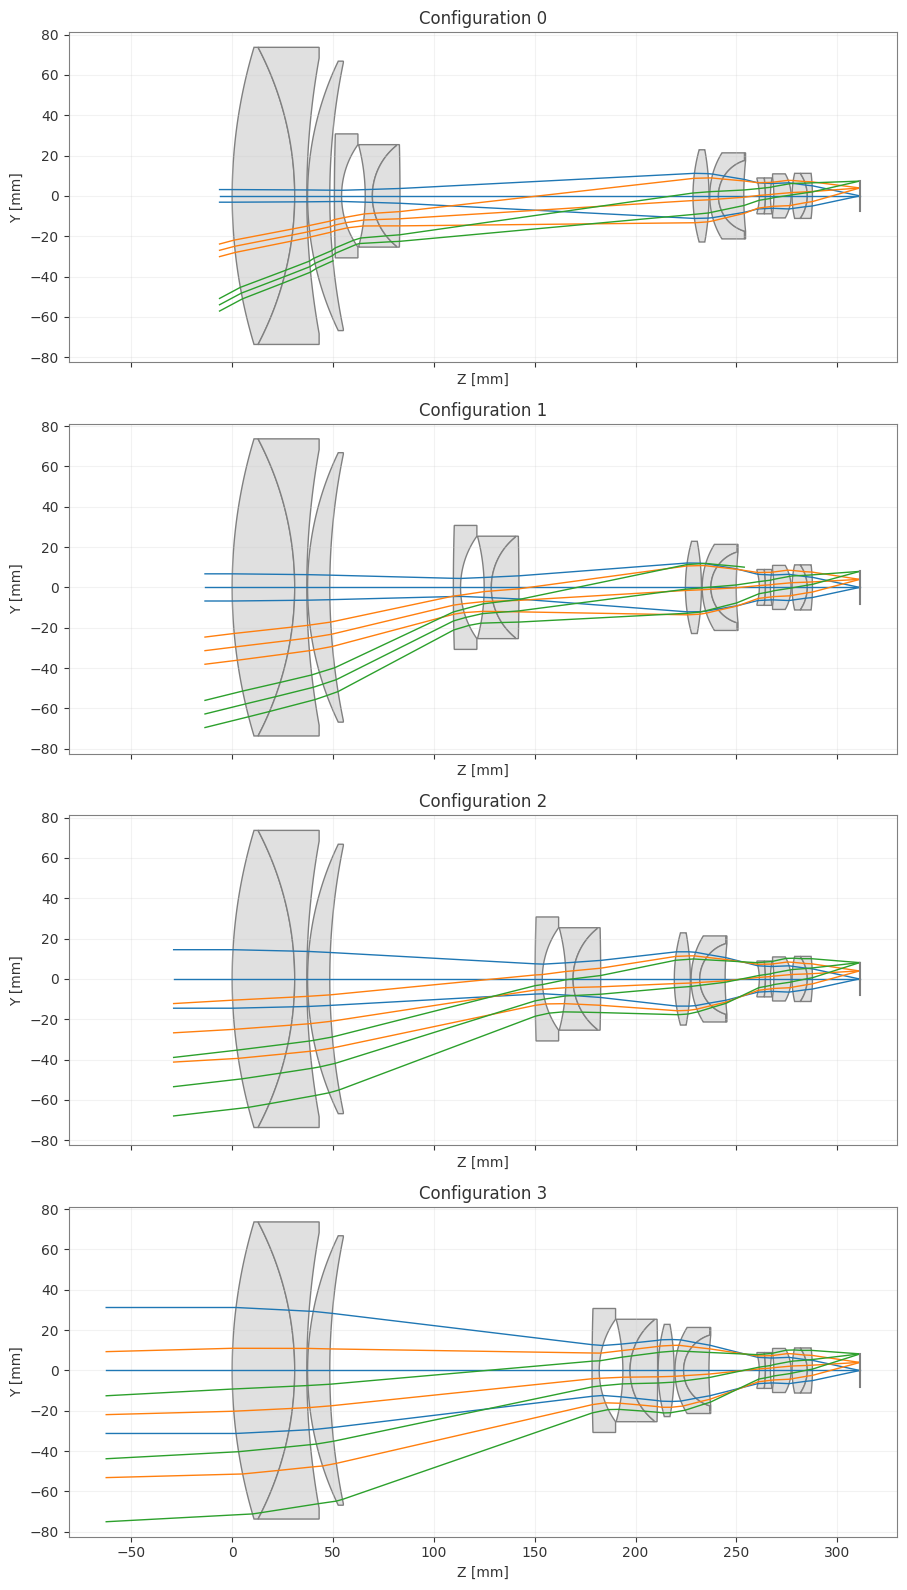

In [4]:
_ = mc.draw()

## Optimization

We can optimize the system by defining variables and operands. In a multi-configuration system, variables can be applied to common surfaces (affecting all configurations due to pickups) or to specific independent parameters.

Here, we demonstrate a simple optimization setup.

In [5]:
problem = OptimizationProblem()

# 1. Add Variables
# Optimize radius of surface 1. Since other configurations are linked to this surface
# by default (via pickups), optimizing the base optic (mechanically shared) affects all.
problem.add_variable(optic=mc.configurations[0], variable_type='radius', surface_number=1)

# Optimize the spacing after surface 5 for Configuration 1
problem.add_variable(optic=mc.configurations[1], variable_type='thickness', surface_number=5)

# 2. Add Operands
# Target EFL for Config 0
problem.add_operand(operand_type='f2', target=0.591*25.4, weight=1.0, input_data={'optic': mc.configurations[0]})
# Target EFL for Config 1
problem.add_operand(operand_type='f2', target=1.272*25.4, weight=1.0, input_data={'optic': mc.configurations[1]})

# 3. Run Optimization
optimizer = LeastSquares(problem)
optimizer.optimize(maxiter=5)

# Check results
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            1.74162e-21 │               100 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │   15.011 │              │              │        1 │  15.011 │       0 │           0.01 │
│  1 │ f2             │   32.309 │              │              │        1 │  32.309 │       0 │          99.99 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤══════════╤══════════════╤

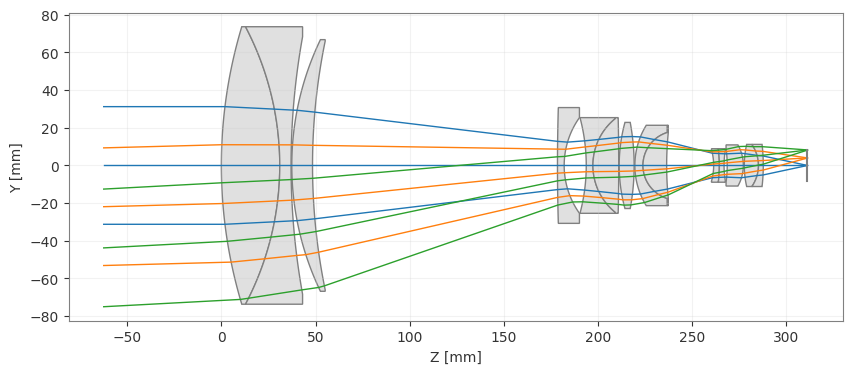

In [6]:
# View the final design for configuration 3
_ = mc.configurations[3].draw()